# Bert model

This part we will use bert model and add an output layer to do the classficiation job.

In [ ]:
!pip install transformers datasets evaluate

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from sklearn.model_selection import train_test_split
import torch
from torch.utils.data import DataLoader
from transformers import BertTokenizer, BertForSequenceClassification, AdamW, AutoTokenizer
from transformers import BertTokenizer, BertForSequenceClassification, AdamW
import pandas as pd
from sklearn.metrics import accuracy_score
from transformers import AutoModelForSequenceClassification, TrainingArguments, Trainer

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
%cd '/content/drive/MyDrive/deep_learning'

/content/drive/MyDrive/deep_learning


In [ ]:
#merged_feeling_text_df = pd.read_csv('preprocessed.csv')

In [ ]:
#train, test = train_test_split(merged_feeling_text_df, test_size=0.2, random_state=0)

In [ ]:
train = pd.read_csv('train_data.csv')
train, test = train_test_split(train, test_size=0.2, random_state=0)
train = train.sample(frac=0.01,random_state=42)
test = test.sample(frac=0.01, random_state=42)

In [ ]:
#test = pd.read_csv('test_data.csv')
#test = test.sample(frac=0.01, random_state=42)

In [ ]:
model_name = 'distilbert-base-uncased'
device = torch.device('cuda')
tokenizer = BertTokenizer.from_pretrained(model_name , do_basic_tokenize=False, num_threads=4, device = device)
model = BertForSequenceClassification.from_pretrained(model_name, num_labels=2)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'DistilBertTokenizer'. 
The class this function is called from is 'BertTokenizer'.
You are using a model of type distilbert to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.
Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing BertForSequenceClassification: ['distilbert.transformer.layer.1.output_layer_norm.weight', 'distilbert.transformer.layer.5.attention.v_lin.weight', 'distilbert.transformer.layer.2.output_layer_norm.weight', 'distilbert.transformer.layer.4.ffn.lin1.bias', 'distilbert.transformer.layer.4.attention.out_lin.weight', 'vocab_layer_norm.weight', 'distilbert.transformer.layer.2.ffn.lin1.bias', 'distilbert.transformer.layer.1.attention.out_lin.bias', 'distilber

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12,

In [ ]:
#test_encodings = tokenizer(test['text'].apply(lambda x: str(x)).tolist(), truncation=True, padding=True)
#train_encodings = tokenizer(train['text'].apply(lambda x: str(x)).tolist(), truncation=True, padding=True)


In [ ]:
import torch
from torch.utils.data import Dataset

class ClassificationDataset(Dataset):
    def __init__(self, encodings, labels):
        self.input_ids = encodings["input_ids"]
        self.attention_mask = encodings["attention_mask"]
        self.labels = labels

    def __getitem__(self, idx):
        item = {
            "input_ids": torch.tensor(self.input_ids[idx]),
            "attention_mask": torch.tensor(self.attention_mask[idx]),
            "labels": torch.tensor(self.labels[idx])
        }
        return item

    def __len__(self):
        return len(self.labels)

In [ ]:
import torch
from torch.utils.data import DataLoader
from transformers import DistilBertTokenizer, DistilBertForSequenceClassification, AdamW

# Define the text classification dataset
class ClassificationDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

# Load the tokenizer and model
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
model = DistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased')

# Define the dataset
train_encodings = tokenizer(train['text'].tolist(), truncation=True, padding=True)
train_labels = train['label'].tolist()
train_dataset = ClassificationDataset(train_encodings, train_labels)

# Prepare the test data
test_encodings = tokenizer(test['text'].tolist(), truncation=True, padding=True)
test_labels = test['label'].tolist()
test_dataset = ClassificationDataset(test_encodings, test_labels)



# Set model to evaluation mode

# Define the data loader
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

# Define the data loader for the test set
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Set device (GPU if available)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)



Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_layer_norm.bias', 'vocab_projector.weight', 'vocab_projector.bias', 'vocab_layer_norm.weight', 'vocab_transform.bias', 'vocab_transform.weight']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['pre_classifier.weight', 'classifier.weight', 'classifi

DistilBertForSequenceClassification(
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0-5): 6 x TransformerBlock(
          (attention): MultiHeadSelfAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)
 

In [ ]:
from sklearn.metrics import accuracy_score
learning_rate = 2e-5
optimizer = AdamW(model.parameters(), lr=learning_rate)
# Training loop
num_epochs = 20
model.train()

train_acc_list = []
test_acc_list = []

for epoch in range(num_epochs):
    # Training
    total_loss = 0
    total_predictions = []
    total_labels = []

    for batch in train_loader:
        optimizer.zero_grad()
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        total_loss += loss.item()

        loss.backward()
        optimizer.step()

        predicted_labels = torch.argmax(outputs.logits, dim=1).tolist()
        total_predictions.extend(predicted_labels)
        total_labels.extend(labels.tolist())

    average_loss = total_loss / len(train_loader)
    accuracy = accuracy_score(total_labels, total_predictions)
    train_acc_list.append(accuracy)
    print(f"Epoch {epoch+1}/{num_epochs} - Average Loss: {average_loss} - Training Accuracy: {accuracy}")

    # Validation
    model.eval()
    total_predictions = []
    total_labels = []

    with torch.no_grad():
        for batch in test_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            outputs = model(input_ids, attention_mask=attention_mask)
            logits = outputs.logits

            predicted_labels = torch.argmax(logits, dim=1).tolist()
            total_predictions.extend(predicted_labels)
            total_labels.extend(labels.tolist())

    accuracy = accuracy_score(total_labels, total_predictions)
    test_acc_list.append(accuracy)
    print(f"Validation Accuracy: {accuracy}")


/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:407: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1/20 - Average Loss: 0.6648848873597605 - Training Accuracy: 0.6056173200702165
Validation Accuracy: 0.7142857142857143
Epoch 2/20 - Average Loss: 0.561910977518117 - Training Accuracy: 0.7097717963721475
Validation Accuracy: 0.7517564402810304
Epoch 3/20 - Average Loss: 0.3868334914247195 - Training Accuracy: 0.8320655354008192
Validation Accuracy: 0.7447306791569087
Epoch 4/20 - Average Loss: 0.15995526679412084 - Training Accuracy: 0.9479227618490346
Validation Accuracy: 0.6604215456674473
Epoch 5/20 - Average Loss: 0.0562074280999325 - Training Accuracy: 0.9853715623171445
Validation Accuracy: 0.7189695550351288
Epoch 6/20 - Average Loss: 0.014886721218418743 - Training Accuracy: 0.9970743124634289
Validation Accuracy: 0.7306791569086651
Epoch 7/20 - Average Loss: 0.00437740801350662 - Training Accuracy: 1.0
Validation Accuracy: 0.7353629976580797
Epoch 8/20 - Average Loss: 0.0025132352882927217 - Training Accuracy: 1.0
Validation Accuracy: 0.7236533957845434
Epoch 9/20 - Ave

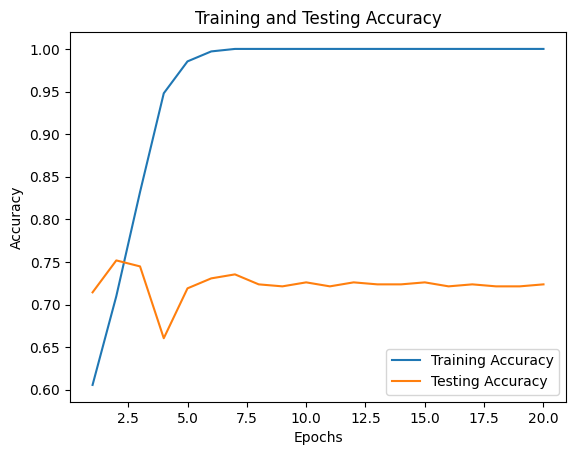

In [ ]:
import matplotlib.pyplot as plt

# Create x-axis values
epochs = range(1, len(train_acc_list) + 1)

# Plot training and testing accuracy
plt.plot(epochs, train_acc_list, label='Training Accuracy')
plt.plot(epochs, test_acc_list, label='Testing Accuracy')

# Set labels and title
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Testing Accuracy')

# Set legend
plt.legend()

# Display the plot
plt.show()


## 